Annie T making minimal edits just to get this running, trying to keep it as their workflow though

In [32]:
import geemap
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Earth Engine library.
# ee.Authenticate()

# Data Load & Preprocessing

In [2]:
# CHANGE THIS
# assets_path = 'projects/ee-aprilmchang/assets/'
assets = 'projects/ee-annalisertaylor/assets/TNC/agplastics/'

In [3]:
ee.Initialize()

# Load data from counties (except Oxnard which has a different format)
# fc_SantaMaria = ee.FeatureCollection(assets_path + 'tnc/tnc-training-data/SantaMaria')
# fc_Mendocino = ee.FeatureCollection(assets_path + 'tnc/tnc-training-data/Mendocino')
# fc_Watsonville = ee.FeatureCollection(assets_path + 'tnc/tnc-training-data/Watsonville')

fc_SantaMaria = ee.FeatureCollection(assets + 'SantaMaria_val')
fc_Mendocino = ee.FeatureCollection(assets + 'Mendocino_val')
fc_Watsonville = ee.FeatureCollection(assets + 'Watsonville_val')

# Encode labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'greenhouse': 3}

In [4]:
# Cloud mask for Sentinel-2
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

def processImageCollection(imageCollection, aoi, startDate, endDate):
    # Define functions for band calculations
    def addNDVI(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi)

    def addNDTI(image):
        ndti = image.normalizedDifference(['B11', 'B12']).rename('NDTI')
        return image.addBands(ndti)

    def addPGI(image):
        NIR = image.select('B8')
        R = image.select('B4')
        G = image.select('B3')
        B = image.select('B2')
        pgi = NIR.subtract(R).multiply(100).multiply(R).divide(NIR.add(B).add(G).divide(3).subtract(1)).rename('PGI')
        return image.addBands(pgi)

    def addPMLI(image):
        SWIR1 = image.select('B11')
        R = image.select('B4')
        pmli = SWIR1.subtract(R).divide(SWIR1.add(R)).rename('PMLI')
        return image.addBands(pmli)

    def addRPGI(image):
        NIR = image.select('B8')
        R = image.select('B4')
        G = image.select('B3')
        B = image.select('B2')
        rpgi = B.multiply(100).divide(NIR.add(B).add(G).divide(3).subtract(1)).rename('RPGI')
        return image.addBands(rpgi)

    def addDistanceToCoast(image):
        # Load the JRC Global Surface Water dataset
        water = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')

        # Create a binary mask for water bodies
        water_mask = water.gt(0)  # Greater than 0% occurrence of water

        # Calculate the distance to the nearest water body
        distance = water_mask.Not().fastDistanceTransform().sqrt().multiply(ee.Image.pixelArea().sqrt())

        # Convert distance to kilometers and add as a band
        distance = distance.divide(1000).rename('distance_to_coast')

        return image.addBands(distance)

    # Function to add SRTM elevation data
    def addElevation(image):
        elevation = ee.Image('USGS/SRTMGL1_003').rename('elevation')
        return image.addBands(elevation)

    # Apply functions to image collection
    processedCollection = (imageCollection
                           .filterDate(startDate, endDate)
                           .filterBounds(aoi)
                           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
                           .map(maskS2clouds)
                           .map(addNDVI)
                           .map(addNDTI)
                           .map(addPGI)
                           .map(addPMLI)
                          #  .map(addRPGI)
                           .map(addDistanceToCoast)
                           .map(addElevation))

    return processedCollection

In [5]:
# Select bands for image
bands = [
  # Spectrum Features
  'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
  # Index Features
  'NDVI', 'NDTI', 'PGI', 'PMLI',
  # Additional Geographical features
  'distance_to_coast', 'elevation'
]

In [6]:
def get_collection_on_date(df, county, date, roi):
  # Filter for date
  df_date = df[df["Date"]==date]

  # Get coordinates as a list
  points = []
  for idx, row in df_date.iterrows():
      point = ee.Geometry.Point([row['Longitude'], row['Latitude']])
      feature = ee.Feature(point, {'class': row['NumericType']})
      points.append(feature)

  fc = ee.FeatureCollection(points)

  # Get image for a month's range
  date_ = datetime.strptime(date, "%Y-%m-%d")
  start = (date_ - timedelta(days=10)).strftime("%Y-%m-%d")
  end = (date_ + timedelta(days=10)).strftime("%Y-%m-%d")
  processedCollection = processImageCollection(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED'), roi, start, end)
  image = processedCollection.median().clip(roi)

  # Sample points from image
  data = image.select(bands).sampleRegions(
    collection=fc,
    properties=['class'],
    scale=30,
    geometries=True
  )

  print(f"Total number of labeled data for {date} in {county}:", data.size().getInfo())

  return data

In [7]:
from datetime import datetime, timedelta

class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'greenhouse': 3}

def processCountyFeatureCollection(fc, county):
  # Make dataframe
  dict_list = [feat['properties'] for feat in fc.getInfo()['features']]
  df = pd.DataFrame(dict_list)

  # Encode labels
  df['NumericType'] = df['Type'].map(class_mapping)

  # Drop greenhouse type (for now)
  df = df[df["Type"]!="greenhouse"]

  # Format dates to YYYY-MM-DD
  df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

  # Filter for dates when Sentinel-2 is available
  df = df[df['Date'] > '2018-05-09']

  # County boundaries based off csv coordinates
  min_lon = df['Longitude'].min()
  max_lon = df['Longitude'].max()
  min_lat = df['Latitude'].min()
  max_lat = df['Latitude'].max()

  roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

  # Iterate through unique dates
  dates = df["Date"].unique()
  all_county_data = []
  for date in dates:
    all_county_data.append(get_collection_on_date(df, county, date, roi))
  county_fc = ee.FeatureCollection(all_county_data).flatten()
  print(f"Total number of labeled data in {county}:", county_fc.size().getInfo())
  return county_fc

In [8]:
data_SantaMaria = processCountyFeatureCollection(fc_SantaMaria, "Santa Maria")

C:\Users\annalise.taylor\AppData\Local\anaconda3\envs\plastic\Lib\site-packages\ee\deprecation.py:204: DeprecationWarning: 

Attention required for JRC/GSW1_3/GlobalSurfaceWater! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_GlobalSurfaceWater

  warnings.warn(warning, category=DeprecationWarning)


Total number of labeled data for 2022-08-26 in Santa Maria: 154
Total number of labeled data for 2023-05-05 in Santa Maria: 341
Total number of labeled data for 2022-03-10 in Santa Maria: 307
Total number of labeled data for 2021-02-06 in Santa Maria: 147
Total number of labeled data in Santa Maria: 949


In [9]:
data_Mendocino = processCountyFeatureCollection(fc_Mendocino, "Mendocino")

Total number of labeled data for 2021-06-02 in Mendocino: 263
Total number of labeled data in Mendocino: 263


In [10]:
data_Watsonville = processCountyFeatureCollection(fc_Watsonville, "Watsonville")

Total number of labeled data for 2020-09-26 in Watsonville: 404
Total number of labeled data for 2021-09-27 in Watsonville: 447
Total number of labeled data for 2022-09-11 in Watsonville: 475
Total number of labeled data for 2023-04-12 in Watsonville: 463
Total number of labeled data in Watsonville: 1789


In [11]:
# Load data from Oxnard
START = '2019-02-01'
END = '2019-06-01'

# Boundary_Oxnard = ee.FeatureCollection(assets_path + 'tnc/Oxnard')
# polygons_label_mulch_hoop = ee.FeatureCollection(assets_path + 'tnc/tnc-training-data/label_mulch_hoop')
# polygons_label_nonplastic = ee.FeatureCollection(assets_path + 'tnc/tnc-training-data/label_nonplastic')
# polygons = polygons_label_mulch_hoop.merge(polygons_label_nonplastic)
# aoi_truck_crop = ee.FeatureCollection(assets_path + 'tnc/TruckCrops')

assets = 'projects/ee-annalisertaylor/assets/TNC/agplastics/'
Boundary_Oxnard = ee.FeatureCollection(assets + 'Oxnard')
polygons_label_mulch_hoop = ee.FeatureCollection(assets + 'label_mulch_hoop')
polygons_label_nonplastic = ee.FeatureCollection(assets + 'label_nonplastic')
polygons = polygons_label_mulch_hoop.merge(polygons_label_nonplastic)
aoi_truck_crop = ee.FeatureCollection(assets + 'T')

In [12]:
processedCollection = processImageCollection(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED'), Boundary_Oxnard, START, END)
image = processedCollection.median().clip(aoi_truck_crop).clip(Boundary_Oxnard)
data_Oxnard = image.sampleRegions(
    collection=polygons,
    properties=['class'],
    scale=30,
    geometries=True
)
print(f"Total number of labeled data in Oxnard:", data_Oxnard.size().getInfo())

Total number of labeled data in Oxnard: 2125


In [13]:
# data_Oxnard.limit(10) # oxnard has distance to coast and elevation
# data_Watsonville.limit(10) # watsonville didn't on 7/2 but did on 7/3, now working

In [14]:
# Combine all data
all_data = []
all_data.append(data_SantaMaria)
all_data.append(data_Mendocino)
all_data.append(data_Watsonville)
all_data.append(data_Oxnard)

# Prepare Train and Validation data

In [15]:
# Process data (1): Train test split
data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)
print(f"Total number of labeled data:", data.size().getInfo())
split = 0.7
training = data.filter(ee.Filter.lt('random', split))
validation = data.filter(ee.Filter.gte('random', split))
print(f"Number of training: {training.size().getInfo()}")
print(f"Number of validation: {validation.size().getInfo()}")

data.limit(10)

Total number of labeled data: 5126
Number of training: 3612
Number of validation: 1514


In [16]:
# Check number of data in each county
filter_SantaMaria = ee.Filter.stringStartsWith('system:index', '0')
filter_Mendocino = ee.Filter.stringStartsWith('system:index', '1')
filter_Watsonville = ee.Filter.stringStartsWith('system:index', '2')
filter_Oxnard = ee.Filter.stringStartsWith('system:index', '3')
print(f"Number of training in Santa Maria: {training.filter(filter_SantaMaria).size().getInfo()}")
print(f"Number of training in Mendocino: {training.filter(filter_Mendocino).size().getInfo()}")
print(f"Number of training in Watsonville: {training.filter(filter_Watsonville).size().getInfo()}")
print(f"Number of training in Oxnard: {training.filter(filter_Oxnard).size().getInfo()}")
print(f"Number of validation in Santa Maria: {validation.filter(filter_SantaMaria).size().getInfo()}")
print(f"Number of validation in Mendocino: {validation.filter(filter_Mendocino).size().getInfo()}")
print(f"Number of validation in Watsonville: {validation.filter(filter_Watsonville).size().getInfo()}")
print(f"Number of validation in Oxnard: {validation.filter(filter_Oxnard).size().getInfo()}")

Number of training in Santa Maria: 667
Number of training in Mendocino: 180
Number of training in Watsonville: 1265
Number of training in Oxnard: 1500
Number of validation in Santa Maria: 282
Number of validation in Mendocino: 83
Number of validation in Watsonville: 524
Number of validation in Oxnard: 625


In [17]:
# Process data (2): Address autocorrelation correction
distFilter = ee.Filter.withinDistance(
    distance=30,
    leftField='.geo',
    rightField='.geo',
    maxError=10
)
join = ee.Join.inverted()
training = join.apply(training, validation, distFilter)
print(f"Number of training after removing autocorrelation: {training.size().getInfo()}")

Number of training after removing autocorrelation: 1981


In [18]:
# Check number of training data in each region again
print(f"Number of training in Santa Maria: {training.filter(filter_SantaMaria).size().getInfo()}")
print(f"Number of training in Mendocino: {training.filter(filter_Mendocino).size().getInfo()}")
print(f"Number of training in Watsonville: {training.filter(filter_Watsonville).size().getInfo()}")
print(f"Number of training in Oxnard: {training.filter(filter_Oxnard).size().getInfo()}")

Number of training in Santa Maria: 622
Number of training in Mendocino: 94
Number of training in Watsonville: 829
Number of training in Oxnard: 436


In [19]:
for class_name, class_id in class_mapping.items():
  filter_class = ee.Filter.eq('class', class_id)
  print(f"Number of points labeled {class_name}: {training.filter(filter_class).size().getInfo()}")

Number of points labeled hoop: 601
Number of points labeled mulch: 546
Number of points labeled other: 834
Number of points labeled greenhouse: 0


# Train and Evaluate Models

In [20]:
def train_model(classifier, training, bands):
  trained_classifier = classifier.train(training, 'class', bands)
  return trained_classifier, trained_classifier.confusionMatrix()
def evaluate_model(trained_classifier, validation):
  classifications = validation.classify(trained_classifier)
  return classifications, classifications.errorMatrix('class', 'classification')

In [21]:
# Define image bands
bands = ['B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
  'NDVI', 'NDTI', 'PGI', 'PMLI']

In [42]:
# Accuracy for Model 1: SVM
trained_SVM, trainAccuracy_SVM = train_model(ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10), training, bands)
_, validationAccuracy_SVM = evaluate_model(trained_SVM, validation)
print("SVM:")
print(f"\tTraining accuracy:{trainAccuracy_SVM.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_SVM.accuracy().getInfo()}")

# Accuracy for Model 2: CART
trained_CART, trainAccuracy_CART = train_model(ee.Classifier.smileCart(), training, bands)
_, validationAccuracy_CART = evaluate_model(trained_CART, validation)
print("CART:")
print(f"\tTraining accuracy:{trainAccuracy_CART.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_CART.accuracy().getInfo()}")

# Accuracy for Model 3: RF
trained_RF, trainAccuracy_RF = train_model(ee.Classifier.smileRandomForest(50), training, bands)
classifications_RF, validationAccuracy_RF = evaluate_model(trained_RF, validation)
print("RF:")
print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")

# Accuracy for Model 4: GTB
trained_GTB, trainAccuracy_GTB = train_model(ee.Classifier.smileGradientTreeBoost(50), training, bands)
classifications_GTB, validationAccuracy_GTB = evaluate_model(trained_GTB, validation)
print("GTB:")
print(f"\tTraining accuracy:{trainAccuracy_GTB.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_GTB.accuracy().getInfo()}")


SVM:
	Training accuracy:0.8384654215042907
	Validation accuracy:0.8025099075297226
CART:
	Training accuracy:1
	Validation accuracy:0.7985468956406869
RF:
	Training accuracy:0.9934376577486118
	Validation accuracy:0.8579920739762219
GTB:
	Training accuracy:0.9717314487632509
	Validation accuracy:0.8566710700132101


In [43]:
# Accuracy values
model_names = ["SVM", "CART", "RF", "GTB"]
train_accuracies = [trainAccuracy_SVM.accuracy().getInfo(),
                   trainAccuracy_CART.accuracy().getInfo(),
                   trainAccuracy_RF.accuracy().getInfo(),
                   trainAccuracy_GTB.accuracy().getInfo()]
validation_accuracies = [validationAccuracy_SVM.accuracy().getInfo(),
                        validationAccuracy_CART.accuracy().getInfo(),
                        validationAccuracy_RF.accuracy().getInfo(),
                        validationAccuracy_GTB.accuracy().getInfo()]

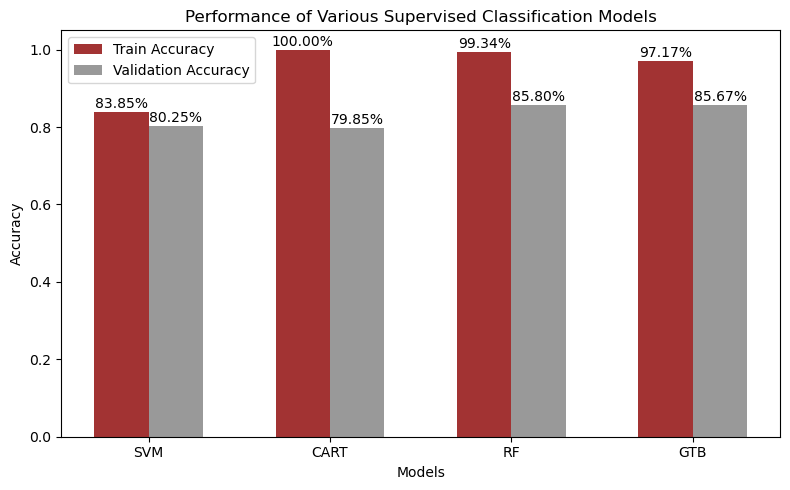

In [44]:
# Define the width of each bar and the positions of the bars
bar_width = 0.3
index = np.arange(len(model_names))
train_color = 'darkred'
validation_color = 'grey'

# Plotting
plt.figure(figsize=(8, 5))
bars1 = plt.bar(index, train_accuracies, bar_width, label='Train Accuracy', color=train_color, alpha=0.8)
bars2 = plt.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color=validation_color, alpha=0.8)

# Add percentage values on top of the bars
for bar1, bar2 in zip(bars1, bars2):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + 0.01, f'{bar1.get_height():.2%}', ha='center', color='black', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() + 0.01, f'{bar2.get_height():.2%}', ha='center', color='black', fontsize=10)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Performance of Various Supervised Classification Models')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Plot confusion matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
display_labels = ["hoop", "mulch", "other"]

In [46]:
# Accuracy for Model 3: RF
trained_RF, trainAccuracy_RF = train_model(ee.Classifier.smileRandomForest(50), training, bands)
classifications_RF, validationAccuracy_RF = evaluate_model(trained_RF, validation)
print("RF:")
print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")

RF:
	Training accuracy:0.9934376577486118
	Validation accuracy:0.8579920739762219


Text(0.5, 1.0, 'RF Confusion Matrix (85.80% Accuracy)')

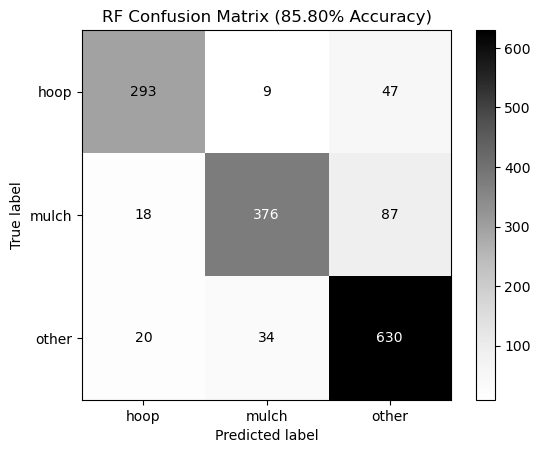

In [47]:
cm_RF = np.array(validationAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF,
                              display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({validationAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

In [48]:
def plot_each_county_cm(cm_Counties):
  f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

  for i, (county, cm) in enumerate(cm_Counties.items()):
      disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm.getInfo()),
                                    display_labels=display_labels)
      disp.plot(ax=axes[i], cmap=plt.cm.Blues)
      disp.ax_.set_title(f"{county} ({cm.accuracy().getInfo():.2%} Accuracy)")
      disp.im_.colorbar.remove()
      disp.ax_.set_xlabel('')
      if i!=0:
          disp.ax_.set_ylabel('')

  f.text(0.4, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.2, hspace=0.1)

  f.colorbar(disp.im_, ax=axes)
  plt.show()

In [49]:
cm_SantaMaria = classifications_RF.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino = classifications_RF.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville = classifications_RF.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard = classifications_RF.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties = {"Santa Maria": cm_SantaMaria, "Mendocino": cm_Mendocino, "Watsonville": cm_Watsonville, "Oxnard": cm_Oxnard}

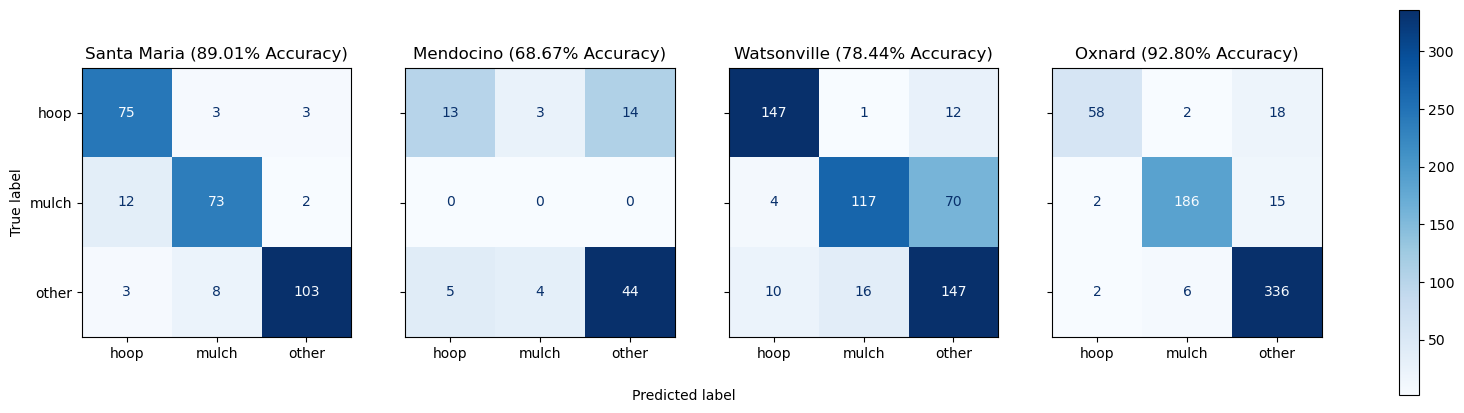

In [50]:
plot_each_county_cm(cm_Counties)

In [51]:
validationAccuracy_RF.fscore().getInfo()

[0.8617647058823529, 0.8355555555555556, 0.8701657458563536]

# Data Augmentation

## Distance to coast

In [72]:
# training.limit(10)
# training data doesn't have elevation or distance to coast
# oxnard data does have this, the error is in the others
# couldn't find an obvious reason in the process county data fn

In [22]:
# RF with Data Augmentation (distance to coast)
trained_RF_coast, trainAccuracy_RF_coast = train_model(ee.Classifier.smileRandomForest(50), training, bands + ['distance_to_coast'])
classifications_RF_coast, validationAccuracy_RF_coast = evaluate_model(trained_RF_coast, validation)
print("RF with Data Augmentation (distance to coast):")
print(f"\tTraining accuracy:{trainAccuracy_RF_coast.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF_coast.accuracy().getInfo()}")

RF with Data Augmentation (distance to coast):
	Training accuracy:0.9934376577486118
	Validation accuracy:0.880449141347424


Text(0.5, 1.0, 'RF Confusion Matrix with Data Augmentation (All 4 counties)')

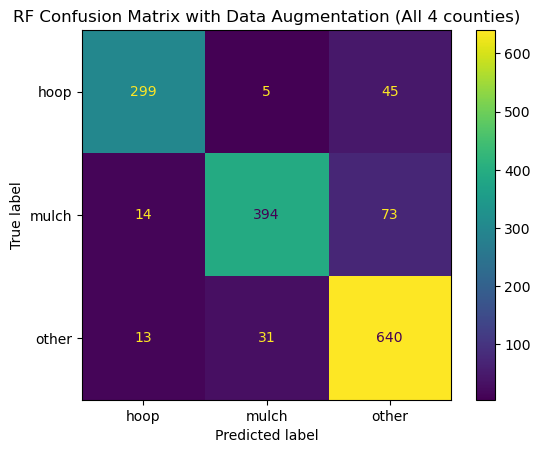

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(validationAccuracy_RF_coast.getInfo()), display_labels = ["hoop", "mulch", "other"])
disp.plot()
disp.ax_.set_title("RF Confusion Matrix with Data Augmentation (All 4 counties)")

In [30]:
cm_SantaMaria_coast = classifications_RF_coast.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino_coast = classifications_RF_coast.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville_coast = classifications_RF_coast.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard_coast = classifications_RF_coast.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties_coast = {"Santa Maria": cm_SantaMaria_coast, "Mendocino": cm_Mendocino_coast, "Watsonville": cm_Watsonville_coast, "Oxnard": cm_Oxnard_coast}

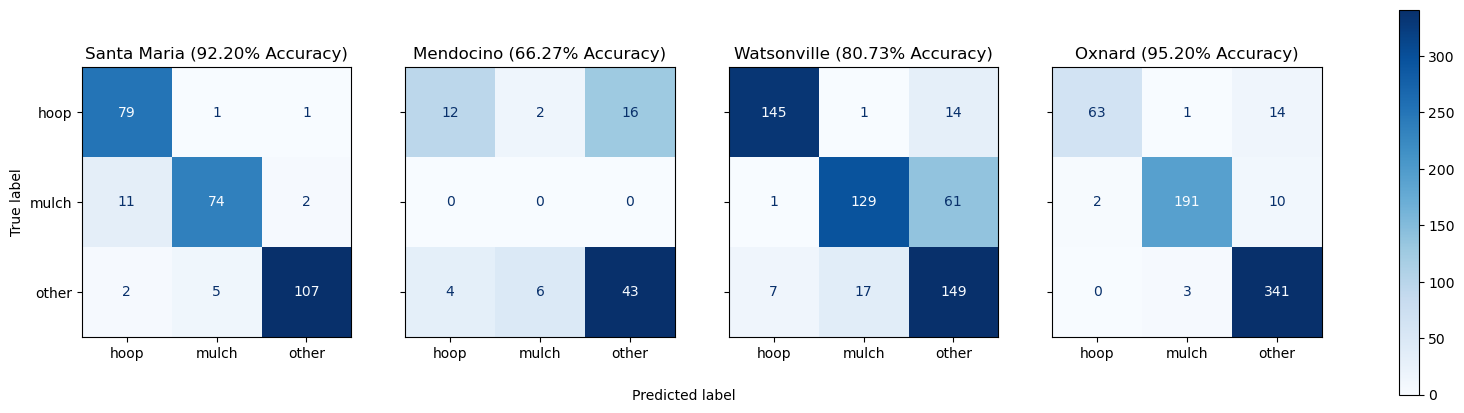

In [33]:
plot_each_county_cm(cm_Counties_coast)

## Elevation

In [34]:
# RF with Data Augmentation (elevation)
trained_RF_elevation, trainAccuracy_RF_elevation = train_model(ee.Classifier.smileRandomForest(50), training, bands + ['elevation'])
classifications_RF_elevation, validationAccuracy_RF_elevation = evaluate_model(trained_RF_elevation, validation)
print("RF with Data Augmentation (elevation):")
print(f"\tTraining accuracy:{trainAccuracy_RF_elevation.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF_elevation.accuracy().getInfo()}")

RF with Data Augmentation (elevation):
	Training accuracy:0.9969712266532055
	Validation accuracy:0.8712021136063408


In [35]:
cm_SantaMaria_elevation = classifications_RF_elevation.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino_elevation = classifications_RF_elevation.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville_elevation = classifications_RF_elevation.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard_elevation = classifications_RF_elevation.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties_elevation = {"Santa Maria": cm_SantaMaria_elevation, "Mendocino": cm_Mendocino_elevation, "Watsonville": cm_Watsonville_elevation, "Oxnard": cm_Oxnard_elevation}

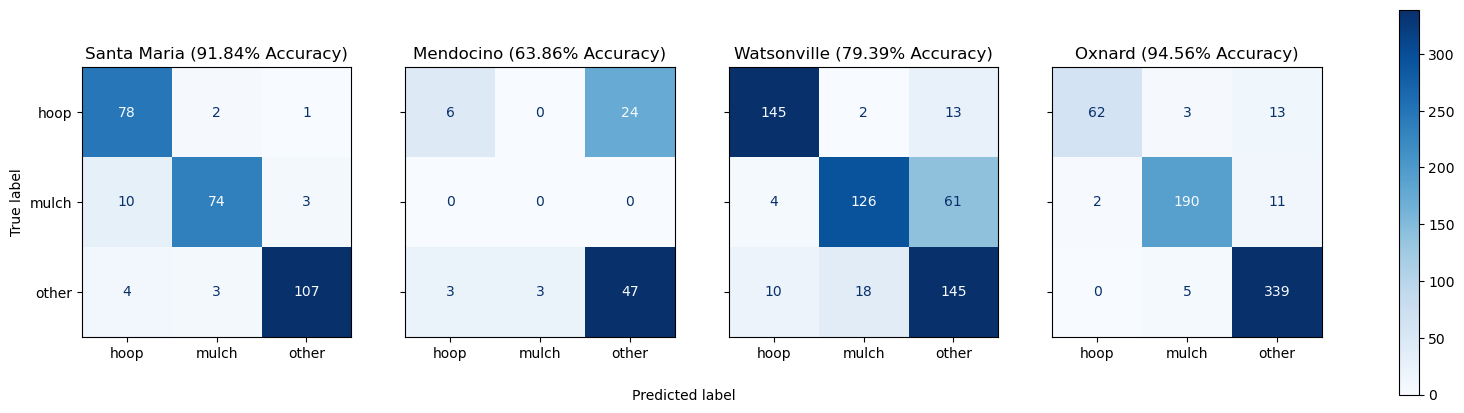

In [36]:
plot_each_county_cm(cm_Counties_elevation)

## Distance to Coast + Elevation

In [37]:
# RF with Data Augmentation (distance to coast + elevation)
trained_RF_all, trainAccuracy_RF_all = train_model(ee.Classifier.smileRandomForest(50), training, bands + ['distance_to_coast', 'elevation'])
classifications_RF_all, validationAccuracy_RF_all = evaluate_model(trained_RF_all, validation)
print("RF with Data Augmentation (distance to coast + elevation):")
print(f"\tTraining accuracy:{trainAccuracy_RF_all.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF_all.accuracy().getInfo()}")

RF with Data Augmentation (distance to coast + elevation):
	Training accuracy:0.9964664310954063
	Validation accuracy:0.8883751651254954


Text(0.5, 1.0, 'RF with Geographical Features\nConfusion Matrix (88.84% Accuracy)')

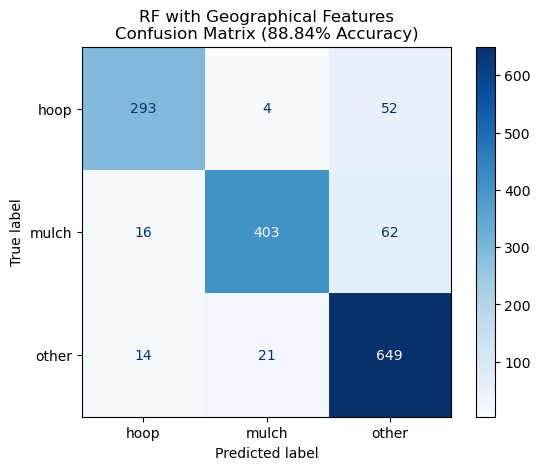

In [38]:
cm_RF_all = np.array(validationAccuracy_RF_all.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF_all,
                              display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title(f"RF with Geographical Features\nConfusion Matrix ({validationAccuracy_RF_all.accuracy().getInfo():.2%} Accuracy)")

In [39]:
cm_SantaMaria_all = classifications_RF_all.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino_all = classifications_RF_all.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville_all = classifications_RF_all.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard_all = classifications_RF_all.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties_all = {"Santa Maria": cm_SantaMaria_all, "Mendocino": cm_Mendocino_all, "Watsonville": cm_Watsonville_all, "Oxnard": cm_Oxnard_all}

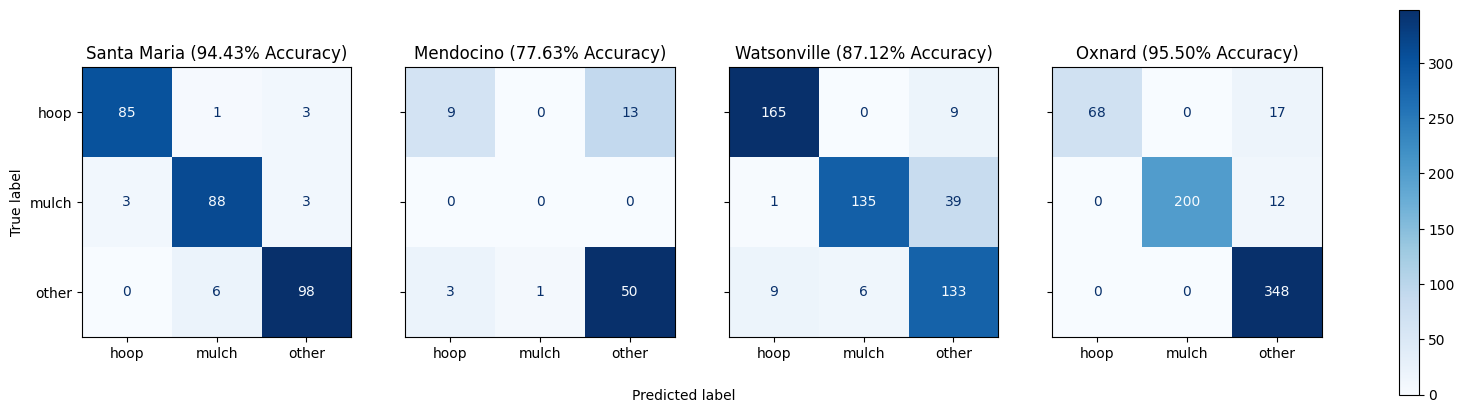

In [ ]:
plot_each_county_cm(cm_Counties_all)

In [52]:
# Define the counties and their accuracy values (without and with augmentation)
counties = ["Santa Maria", "Mendocino", "Watsonville", "Oxnard"]
accuracy_before_augmentation = [cm_SantaMaria.accuracy().getInfo(),
                              cm_Mendocino.accuracy().getInfo(),
                              cm_Watsonville.accuracy().getInfo(),
                              cm_Oxnard.accuracy().getInfo(),]
accuracy_after_augmentation = [cm_SantaMaria_all.accuracy().getInfo(),
                              cm_Mendocino_all.accuracy().getInfo(),
                              cm_Watsonville_all.accuracy().getInfo(),
                              cm_Oxnard_all.accuracy().getInfo(),]

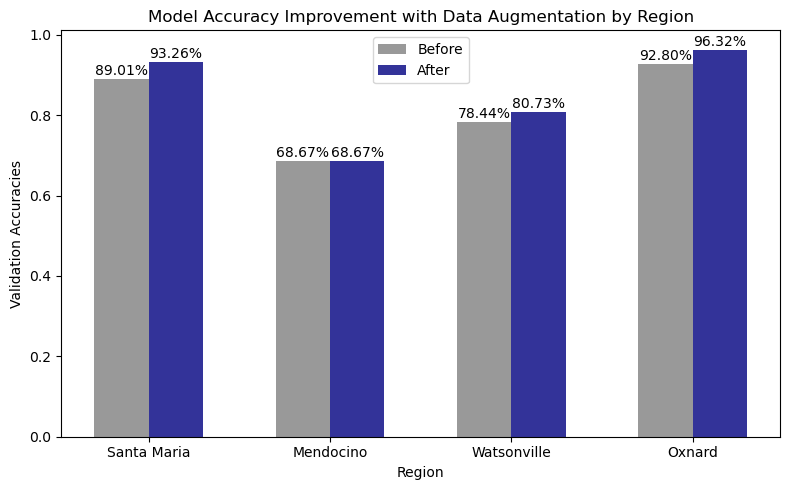

In [53]:
# Set the width of the bars and the positions of the bars
bar_width = 0.3
index = np.arange(len(counties))

# Create the grouped bar chart
plt.figure(figsize=(8, 5))
bars1 = plt.bar(index, accuracy_before_augmentation, bar_width, label='Before', color='grey', alpha=0.8)
bars2 = plt.bar(index + bar_width, accuracy_after_augmentation, bar_width, label='After', color='navy', alpha=0.8)

# Add percentage values on top of the bars
for bar1, bar2 in zip(bars1, bars2):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + 0.01, f'{bar1.get_height():.2%}', ha='center', color='black', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() + 0.01, f'{bar2.get_height():.2%}', ha='center', color='black', fontsize=10)

# Add labels, titles, and legend
plt.xlabel('Region')
plt.ylabel('Validation Accuracies')
plt.title('Model Accuracy Improvement with Data Augmentation by Region')
plt.xticks(index + bar_width / 2, counties)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()

# Save Model

In [54]:
def save_classifier(classifier, model_name, drive_folder):
  trees = ee.List(ee.Dictionary(classifier.explain()).get('trees'))
  dummy = ee.Feature(None)
  col = ee.FeatureCollection(trees.map(lambda x:  dummy.set('tree',x)))
  task = ee.batch.Export.table.toDrive(
    collection=col,
    description=model_name,
    folder=drive_folder
  )
  task.start()

In [55]:
save_classifier(trained_RF, 'trained_RF', 'Earth Engine')
save_classifier(trained_RF_all, 'trained_RF_augmented', 'Earth Engine')